<a href="https://colab.research.google.com/github/ccorbett0116/Fall2025ResearchProject/blob/main/Research_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Title:
# Authors: Jose Henriquez, Cole Corbett
## Description:
The deployment of medical AI systems across different hospitals raises critical questions about whether fairness and representation quality can be reliably transferred across clinical domains. Models trained on one hospital’s imaging data are often reused in new environments where patient demographics, imaging devices, and diagnostic practices differ substantially, potentially resulting in unintended bias against certain groups. This project investigates this challenge by studying fairness-aware representation alignment in medical imaging. The student will train contrastive learning models—such as SimCLR—independently on two large-scale chest X-ray datasets: CheXpert (from Stanford Hospital) and MIMIC-CXR (from Beth Israel Deaconess Medical Center). After learning embeddings in each domain, the student will apply domain alignment techniques such as Procrustes alignment to map representations from the CheXpert embedding space into the MIMIC-CXR space. The aligned embeddings will then be evaluated using fairness metrics designed for representation spaces, including demographic subgroup alignment, intra- vs. inter-group embedding disparity, and cluster-level demographic parity. The expected outcome is a rigorous understanding of whether fairness properties learned in one hospital setting preserve, degrade, or improve when transferred to another, revealing how robust model fairness is to realworld clinical domain shifts. A practical use case involves a healthcare network seeking to deploy a model trained at a major academic hospital (e.g., Stanford) into a community hospital setting: this project helps determine whether the transferred representations remain equitable across patient groups such as older adults, women, or specific disease cohorts. The findings will support responsible AI deployment in healthcare by highlighting the conditions under which fairness is stable across institutions and identifying scenarios where domain-specific mitigation strategies may be required.

In [2]:
#Process is probably different on colab, this is hyperspecific to me because I'm working on Pycharm connected to my WSL
import sys
import os
!{sys.executable} -m pip install kagglehub polars numpy
#We're going to use polars because it's significantly faster, it's build on rust and enables multi-threaded processing as well as some memory optimizations over pandas.

# Install PyTorch with CUDA 13.0 support (LINUX Link (May work for windows??))
!{sys.executable} -m pip install torch torchvision --index-url https://download.pytorch.org/whl/cu130

# Install PyTorch Lightning and Lightning Bolts for SimCLR
!{sys.executable} -m pip install pytorch-lightning lightning-bolts

Looking in indexes: https://download.pytorch.org/whl/cu130
   ---------------------------------------- 0.0/829.5 kB ? eta -:--:--
   ---------------------------------------- 829.5/829.5 kB 17.7 MB/s  0:00:00

  Attempting uninstall: pytorch-lightning

    Found existing installation: pytorch-lightning 2.5.6

    Uninstalling pytorch-lightning-2.5.6:

      Successfully uninstalled pytorch-lightning-2.5.6

   ---------------------------------------- 0/2 [pytorch-lightning]
   ---------------------------------------- 0/2 [pytorch-lightning]
   ---------------------------------------- 0/2 [pytorch-lightning]
   ---------------------------------------- 0/2 [pytorch-lightning]
   ---------------------------------------- 0/2 [pytorch-lightning]
   ---------------------------------------- 0/2 [pytorch-lightning]
   ---------------------------------------- 0/2 [pytorch-lightning]
   ---------------------------------------- 0/2 [pytorch-lightning]
   ---------------------------------------- 0/2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lightning 2.1.2 requires fsspec[http]<2025.0,>2021.06.0, but you have fsspec 2025.9.0 which is incompatible.


In [38]:
# Imports
import random
import numpy as np
from PIL import Image
import kagglehub
import polars as pol
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier


In [4]:
# Hyperparameters



base_model="resnet50"
max_epochs = 20
proj_dim = 128 # How many dimensions to project the image into
base_lr = 1e-3
temperature = 0.5
batch_size = 128

num_workers = 12 # This one just effects cpu utilization/training time


In [5]:
# Download datasets

path_chexpert = kagglehub.dataset_download("mimsadiislam/chexpert")
print("Path to chexpert dataset files:", path_chexpert)

path_mimic = kagglehub.dataset_download("itsanmol124/mimic-cxr")
print("Path to mimic dataset files:", path_mimic)

Path to chexpert dataset files: C:\Users\joseh\.cache\kagglehub\datasets\mimsadiislam\chexpert\versions\1


100%|██████████| 2.04G/2.04G [00:25<00:00, 85.7MB/s]

Extracting files...


Path to mimic dataset files: C:\Users\joseh\.cache\kagglehub\datasets\itsanmol124\mimic-cxr\versions\1


In [6]:
dir_chexpert = os.path.join(path_chexpert, "CheXpert-v1.0-small")
dir_mimic = path_mimic

train_csv_chexpert = os.path.join(dir_chexpert, "train.csv")
valid_csv_chexpert = os.path.join(dir_chexpert, "valid.csv")
full_csv_mimic = os.path.join(dir_mimic, "mimic-cxr.csv")

df_complete_mimic = pol.read_csv(full_csv_mimic)
df_train_chexpert = pol.read_csv(train_csv_chexpert)
df_valid_chexpert = pol.read_csv(valid_csv_chexpert)

df_train_mimic = df_complete_mimic.filter(pol.col("split") == "train")
df_valid_mimic = df_complete_mimic.filter(pol.col("split") == "valid")

In [7]:
df_train_mimic.head()

filename,split,label,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Lung Lesion,Lung Opacity,Normal,Pleural Effusion,Pneumonia,Pneumothorax
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""s50000014.jpg""","""train""","""Normal""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"""s50000052.jpg""","""train""","""Normal""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"""s50000125.jpg""","""train""","""Normal""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"""s50000173.jpg""","""train""","""Normal""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"""s50000198.jpg""","""train""","""Consolidation""",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Check GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("No GPU available, using CPU")
    device = torch.device("cpu")
print(f"Using device: {device}")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
Number of GPUs: 1
Current GPU: NVIDIA GeForce RTX 3080
Using device: cuda


In [9]:
print(dir_mimic+"/train")

C:\Users\joseh\.cache\kagglehub\datasets\itsanmol124\mimic-cxr\versions\1/train


In [10]:
# Use Tensor Cores efficiently on 5080
torch.set_float32_matmul_precision("high")

import ast

# -----------------------
# SimCLR augmentations
# -----------------------
simclr_transform = T.Compose([
    T.Resize(256),
    T.RandomResizedCrop(224, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomApply(
        [T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)],
        p=0.8,
    ),
    T.RandomGrayscale(p=0.2),
    T.ToTensor(),
    # CXRs are essentially grayscale; simple normalization is fine as a start
    T.Normalize(mean=[0.5], std=[0.5]),
])


# -----------------------
# Single-dataset SimCLR Dataset
# -----------------------
class SimCLRDataset(Dataset):
    """
    Unlabeled dataset for SimCLR: returns (view1, view2) per image.
    This handles ONE dataset (CheXpert OR MIMIC).
    """
    def __init__(self, df, root, path_col, transform=None, is_mimic=False):
        self.transform = transform
        self.is_mimic = is_mimic
        
        # df is a Polars DataFrame; df[path_col] is a Series → .to_list()
        rel_paths = df[path_col].to_list()
        
        # Parse MIMIC paths if needed (they're stored as string lists)
        if is_mimic:
            parsed_paths = []
            for p in rel_paths:
                # Parse string representation of list: "['files/p16/...']" -> 'files/p16/...'
                if isinstance(p, str) and p.startswith('['):
                    try:
                        path_list = ast.literal_eval(p)
                        if path_list and len(path_list) > 0:
                            parsed_paths.append(path_list[0])  # Take first element
                    except:
                        print(f"Warning: Could not parse path: {p}")
                else:
                    parsed_paths.append(p)
            rel_paths = parsed_paths
        
        self.paths = [os.path.join(root, p) for p in rel_paths]

        print(f"Total images for this SimCLR dataset: {len(self.paths)}")

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform is None:
            raise ValueError("SimCLRDataset requires a transform.")

        xi = self.transform(img)
        xj = self.transform(img)
        return xi, xj


# -----------------------
# Build DataLoaders
# -----------------------

simclr_train_chexpert = SimCLRDataset(
    df=df_train_chexpert,
    root=path_chexpert,
    path_col="Path",      # CheXpert image path column
    transform=simclr_transform,
    is_mimic=False,
)

simclr_train_loader_chexpert = DataLoader(
    simclr_train_chexpert,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

simclr_train_mimic = SimCLRDataset(
    df=df_train_mimic,
    root=dir_mimic,
    path_col="filename",     # MIMIC image path column
    transform=simclr_transform,
    is_mimic=True,        # Enable MIMIC path parsing
)

simclr_train_loader_mimic = DataLoader(
    simclr_train_mimic,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

Total images for this SimCLR dataset: 223414
Total images for this SimCLR dataset: 83837


In [11]:
# Use Tensor Cores efficiently on 5080
torch.set_float32_matmul_precision("high")

# -----------------------
# SimCLR augmentations
# -----------------------
simclr_transform = T.Compose([
    T.Resize(256),
    T.RandomResizedCrop(224, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomApply(
        [T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)],
        p=0.8,
    ),
    T.RandomGrayscale(p=0.2),
    T.ToTensor(),
    # CXRs are essentially grayscale; simple normalization is fine as a start
    T.Normalize(mean=[0.5], std=[0.5]),
])


# -----------------------
# Single-dataset SimCLR Dataset
# -----------------------
class SimCLRDataset(Dataset):
    """
    Unlabeled dataset for SimCLR: returns (view1, view2) per image.
    This handles ONE dataset (CheXpert OR MIMIC).
    """
    def __init__(self, df, root, path_col, transform=None):
        self.transform = transform
        self.root = root
        
        # df is a Polars DataFrame; df[path_col] is a Series → .to_list()
        rel_paths = df[path_col].to_list()
        self.paths = [os.path.join(root, p) for p in rel_paths]

        print(f"Total images for this SimCLR dataset: {len(self.paths)}")

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform is None:
            raise ValueError("SimCLRDataset requires a transform.")

        xi = self.transform(img)
        xj = self.transform(img)
        return xi, xj


# -----------------------
# Build DataLoaders
# -----------------------

# CheXpert
simclr_train_chexpert = SimCLRDataset(
    df=df_train_chexpert,
    root=path_chexpert,      # CheXpert paths include the subdirectory
    path_col="Path",
    transform=simclr_transform,
)

simclr_train_loader_chexpert = DataLoader(
    simclr_train_chexpert,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

# MIMIC Train
simclr_train_mimic = SimCLRDataset(
    df=df_train_mimic,
    root=path_mimic+"/train",    # Images are in train/ directory
    path_col="filename",     # MIMIC uses 'filename' column
    transform=simclr_transform,
)

simclr_train_loader_mimic = DataLoader(
    simclr_train_mimic,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

Total images for this SimCLR dataset: 223414
Total images for this SimCLR dataset: 83837


In [12]:
class SimCLR(pl.LightningModule):
    def __init__(
        self,
        base_model: str = "resnet34",
        out_dim: int = 128,
        lr: float = 1e-3,
        temperature: float = 0.5,
    ):
        super().__init__()
        self.save_hyperparameters()

        # -------- Encoder (backbone) --------
        if base_model == "resnet34":
            backbone = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        elif base_model == "resnet50":
            backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        else:
            raise ValueError(f"Unsupported base_model: {base_model}")

        feat_dim = backbone.fc.in_features
        backbone.fc = nn.Identity()
        self.encoder = backbone

        # -------- Projection head --------
        self.projector = nn.Sequential(
            nn.Linear(feat_dim, feat_dim),
            nn.ReLU(inplace=True),
            nn.Linear(feat_dim, out_dim),
        )

        self.temperature = temperature
        self.lr = lr

    def forward(self, x):
        h = self.encoder(x)           # [B, feat_dim]
        z = self.projector(h)         # [B, out_dim]
        z = F.normalize(z, dim=1)     # L2-normalize
        return z

    def nt_xent_loss(self, z_i, z_j):
        """
        NT-Xent (InfoNCE) loss used in SimCLR.
        z_i, z_j: [B, D] normalized embeddings for the two views
        """
        batch_size = z_i.size(0)
        z = torch.cat([z_i, z_j], dim=0)   # [2B, D]

        # Cosine similarity matrix: [2B, 2B]
        sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)
        sim = sim / self.temperature

        # Mask out self-similarity on diagonal
        self_mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z.device)
        sim = sim.masked_fill(self_mask, float("-inf"))

        # Positive for each i is i+batch_size (wrap around)
        pos_indices = torch.arange(2 * batch_size, device=z.device)
        pos_indices = (pos_indices + batch_size) % (2 * batch_size)

        loss = F.cross_entropy(sim, pos_indices)
        return loss

    def training_step(self, batch, batch_idx):
        x_i, x_j = batch
        z_i = self(x_i)
        z_j = self(x_j)
        loss = self.nt_xent_loss(z_i, z_j)
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.trainer.max_epochs
        )
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

In [ ]:
lr_monitor = LearningRateMonitor(logging_interval="epoch")

# -----------------------
# Loggers
# -----------------------

tb_logger_chexpert = TensorBoardLogger(
    save_dir="tb_logs",
    name="simclr_chexpert"
)

tb_logger_mimic = TensorBoardLogger(
    save_dir="tb_logs",
    name="simclr_mimic"
)

# -----------------------
# CheXpert SimCLR
# -----------------------
simclr_chexpert = SimCLR(
    base_model=base_model,
    out_dim=proj_dim,
    lr=base_lr,
    temperature=temperature,
)

ckpt_chexpert = ModelCheckpoint(
    dirpath="checkpoints/simclr_chexpert",
    filename="simclr-chexpert-{epoch:02d}-{train_loss:.4f}",
    save_top_k=3,
    monitor="train_loss",
    mode="min",
    save_last=True,
)

trainer_chexpert = pl.Trainer(
    max_epochs=max_epochs,
    accelerator="gpu" if torch.cuda.is_available() else "auto",
    devices=1,
    precision="bf16" if torch.cuda.is_available() else "32",
    callbacks=[ckpt_chexpert, lr_monitor],
    logger=tb_logger_chexpert,
    log_every_n_steps=50,
)


# -----------------------
# MIMIC SimCLR
# -----------------------
simclr_mimic = SimCLR(
    base_model=base_model,
    out_dim=proj_dim,
    lr=base_lr,
    temperature=temperature,
)

ckpt_mimic = ModelCheckpoint(
    dirpath="checkpoints/simclr_mimic",
    filename="simclr-mimic-{epoch:02d}-{train_loss:.4f}",
    save_top_k=3,
    monitor="train_loss",
    mode="min",
    save_last=True,
)

trainer_mimic = pl.Trainer(
    max_epochs=max_epochs,
    accelerator="gpu" if torch.cuda.is_available() else "auto",
    devices=1,
    precision="bf16" if torch.cuda.is_available() else "32",
    callbacks=[ckpt_mimic, lr_monitor],
    logger=tb_logger_mimic,
    log_every_n_steps=50,
)

In [ ]:
# print("=== Training SimCLR on CheXpert ===")
# trainer_chexpert.fit(simclr_chexpert, simclr_train_loader_chexpert)

In [ ]:
# print("=== Training SimCLR on MIMIC ===")
# trainer_mimic.fit(simclr_mimic, simclr_train_loader_mimic)

In [ ]:
# Load trained SimCLR models
simclr_chexpert = SimCLR.load_from_checkpoint("./checkpoints/simclr_chexpert/last.ckpt")
simclr_mimic = SimCLR.load_from_checkpoint("./checkpoints/simclr_mimic/last.ckpt")

simclr_chexpert.eval().cuda()
simclr_mimic.eval().cuda()


In [ ]:
# ===============================
# Validation Transform (NO AUGS)
# ===============================
val_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]),
])


# ===============================
# Validation Datasets
# ===============================
chexpert_val_ds = SimCLRDataset(
    df=df_valid_chexpert,
    root=path_chexpert,
    path_col="Path",
    transform=val_transform,
)

mimic_val_ds = SimCLRDataset(
    df=df_valid_mimic,
    root=path_mimic + "/valid",
    path_col="filename",
    transform=val_transform,
)


# ===============================
# Validation DataLoaders
# ===============================
chexpert_val_loader = DataLoader(
    chexpert_val_ds,
    batch_size=64,
    shuffle=False,
    num_workers=0,
)

mimic_val_loader = DataLoader(
    mimic_val_ds,
    batch_size=64,
    shuffle=False,
    num_workers=0,
)


# ===============================
# Embedding Extraction Function
# ===============================
def extract_embeddings(model, loader):
    model.eval()
    
    model = model.to("cuda" if torch.cuda.is_available() else "cpu")

    all_embeds = []
    with torch.no_grad():
        for (x_i, _) in loader:  # only need one view
            x_i = x_i.to(model.device)
            z = model(x_i)
            all_embeds.append(z.cpu())

    return torch.cat(all_embeds, dim=0)


# ===============================
# Extract Embeddings
# ===============================
emb_chexpert = extract_embeddings(simclr_chexpert, chexpert_val_loader)
emb_mimic   = extract_embeddings(simclr_mimic, mimic_val_loader)

print("CheXpert embeddings:", emb_chexpert.shape)
print("MIMIC embeddings:", emb_mimic.shape)


Total images for this SimCLR dataset: 234
Total images for this SimCLR dataset: 711
cuda:<function is_available at 0x0000022804B68040>
cuda:<function is_available at 0x0000022804B68040>
CheXpert embeddings: torch.Size([234, 128])
MIMIC embeddings: torch.Size([711, 128])


In [24]:
torch.save(emb_chexpert, "emb_chexpert.pt")
torch.save(emb_mimic, "emb_mimic.pt")


### Evaluation of Embeddings

We visualize and quantitatively evaluate the learned SimCLR embeddings to understand how well the model captures meaningful structure in the data.

**t-SNE (t-distributed Stochastic Neighbor Embedding):**  
t-SNE is a nonlinear dimensionality reduction technique that maps high-dimensional embeddings (e.g., 128-D SimCLR vectors) into 2D or 3D space while preserving local neighborhoods. This allows us to visually inspect whether images with similar features or labels cluster together in embedding space.

**Silhouette Score:**  
The silhouette score quantifies cluster quality. For each point \(i\), it is defined as:  
s(i) = (b(i) - a(i)) / max(a(i), b(i))
where \(a(i)\) is the average intra-cluster distance and \(b(i)\) is the average nearest-cluster distance. Scores close to 1 indicate tight, well-separated clusters; scores near 0 or negative indicate overlapping or poorly formed clusters.

**K-Nearest Neighbors (KNN) Accuracy:**  
KNN on the embeddings provides a downstream quantitative measure of representation quality. By predicting labels using the nearest neighbors in embedding space, we assess whether the learned embeddings preserve semantic similarity. Higher accuracy indicates that images with similar labels are close together in embedding space, reflecting the model's ability to learn discriminative and meaningful features.


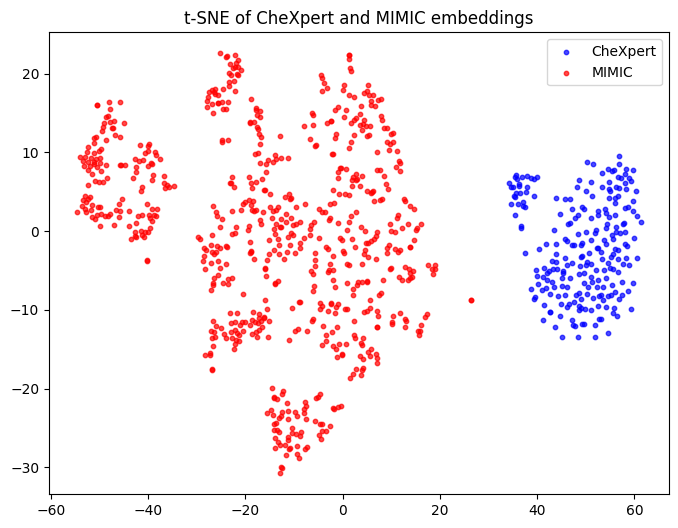

In [40]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Combine embeddings
all_emb = torch.cat([emb_chexpert, emb_mimic], dim=0).cpu().numpy()

# Create labels for coloring: 0 = CheXpert, 1 = MIMIC
labels = np.array([0]*emb_chexpert.shape[0] + [1]*emb_mimic.shape[0])

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(all_emb)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(emb_2d[labels==0, 0], emb_2d[labels==0, 1], s=10, alpha=0.7, label="CheXpert", color="blue")
plt.scatter(emb_2d[labels==1, 0], emb_2d[labels==1, 1], s=10, alpha=0.7, label="MIMIC", color="red")
plt.title("t-SNE of CheXpert and MIMIC embeddings")
plt.legend()
plt.show()


In [41]:
print("CheXpert columns:", df_valid_chexpert.columns)
print("MIMIC columns:", df_valid_mimic.columns)


CheXpert columns: ['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
MIMIC columns: ['filename', 'split', 'label', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Lung Lesion', 'Lung Opacity', 'Normal', 'Pleural Effusion', 'Pneumonia', 'Pneumothorax']


In [42]:
# CheXpert validation labels
chexpert_label_cols = [
    'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
    'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation',
    'Pneumonia', 'Atelectasis', 'Pneumothorax',
    'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices'
]
chexpert_val_labels = df_valid_chexpert.select(chexpert_label_cols).to_numpy()

# MIMIC validation labels
mimic_label_cols = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
    'Enlarged Cardiomediastinum', 'Lung Lesion', 'Lung Opacity',
    'Normal', 'Pleural Effusion', 'Pneumonia', 'Pneumothorax'
]
mimic_val_labels = df_valid_mimic.select(mimic_label_cols).to_numpy()


To quantitatively evaluate our embeddings, we start with the Silhouette Score. This measures how well each data point (here, each X-ray embedding) fits within its assigned class (disease label) compared to other classes. A higher score means the embeddings form more distinct clusters, which indicates that our SimCLR model is capturing meaningful patterns in the images.

In [43]:
from sklearn.metrics import silhouette_score
import numpy as np

# Only consider the disease labels as clusters (ignore 'No Finding' if desired)
# Convert multi-label to single-label by taking argmax for simplicity
chexpert_val_single_label = np.argmax(chexpert_val_labels, axis=1)

# Compute silhouette score
sil_score_chexpert = silhouette_score(emb_chexpert.numpy(), chexpert_val_single_label)
print(f"Silhouette Score (CheXpert embeddings): {sil_score_chexpert:.4f}")


Silhouette Score (CheXpert embeddings): -0.0116


In [44]:
from sklearn.metrics import silhouette_score
import numpy as np

# Only consider the disease labels as clusters (ignore 'No Finding' if desired)
# Convert multi-label to single-label by taking argmax for simplicity
MIMIC_val_single_label = np.argmax(mimic_val_labels, axis=1)

# Compute silhouette score
sil_score_MIMIC = silhouette_score(emb_mimic.numpy(), MIMIC_val_single_label)
print(f"Silhouette Score (MIMIC embeddings): {sil_score_MIMIC:.4f}")


Silhouette Score (MIMIC embeddings): -0.0381


To quantitatively evaluate the quality of our SimCLR embeddings, we can use a K-Nearest Neighbor (KNN) classifier.
The idea is simple: if the embeddings are meaningful, images with the same label should be closer together in embedding space, so a KNN should classify them reasonably well.
This gives a practical, label-based measure of how well the self-supervised embeddings capture relevant structure in the data.

In [45]:
# Use a simple KNN on embeddings
def knn_eval(embeddings, labels, k=5):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(embeddings, labels)
    preds = knn.predict(embeddings)
    acc = accuracy_score(labels, preds)
    return acc

# CheXpert
chexpert_labels = df_valid_chexpert.select([
    'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices'
]).to_numpy()

# Convert one-hot / multi-label to single class for simplicity (e.g., argmax)
chexpert_labels_class = chexpert_labels.argmax(axis=1)

chexpert_knn_acc = knn_eval(emb_chexpert.numpy(), chexpert_labels_class)
print("CheXpert KNN accuracy on embeddings:", chexpert_knn_acc)

# MIMIC
mimic_labels = df_valid_mimic.select([
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
    'Enlarged Cardiomediastinum', 'Lung Lesion', 'Lung Opacity', 'Normal',
    'Pleural Effusion', 'Pneumonia', 'Pneumothorax'
]).to_numpy()
mimic_labels_class = mimic_labels.argmax(axis=1)

mimic_knn_acc = knn_eval(emb_mimic.numpy(), mimic_labels_class)
print("MIMIC KNN accuracy on embeddings:", mimic_knn_acc)

CheXpert KNN accuracy on embeddings: 0.7222222222222222
MIMIC KNN accuracy on embeddings: 0.509142053445851
